In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()

In [3]:
filename = "../data/all_data.json"

df = pd.read_json(filename, convert_dates=["release_date"])
df

,artist,album,release_date,userscore,metascore,link_album,link_img,genres,grammy,billboard
0,Sigur Rós,(),2002-10-29,88.0,82,https://www.metacritic.com/music/()/sigur-ros,https://static.metacritic.com/images/products/...,"[Indie, Rock]",None,None
1,Ed Sheeran,Divide,2017-03-03,47.0,62,https://www.metacritic.com/music/(divide)/ed-s...,https://static.metacritic.com/images/products/...,[Pop/Rock],None,"{'2017': 4, '2018': 5, '2019': 31, '2020': 65}"
2,Ed Sheeran,+,2012-06-12,76.0,67,https://www.metacritic.com/music/+/ed-sheeran,https://static.metacritic.com/images/products/...,[Pop/Rock],None,"{'2012': 136, '2013': 46, '2014': 122, '2015':..."
3,Jewel,0304,2003-06-03,63.0,63,https://www.metacritic.com/music/0304/jewel,https://static.metacritic.com/images/products/...,"[Pop, Adult Alternative, Singer-Songwriter]",None,{'2003': 110}
4,High Places,03/07-09/07,2008-07-22,77.0,81,https://www.metacritic.com/music/0307-0907/hig...,https://static.metacritic.com/images/products/...,[Electronic],None,None
...,...,...,...,...,...,...,...,...,...,...
3241,Joanna Newsom,Ys,2006-11-14,84.0,85,https://www.metacritic.com/music/ys/joanna-newsom,https://static.metacritic.com/images/products/...,"[Indie, Rock, Folk]",None,None
3242,Smashing Pumpkins,Zeitgeist,2007-07-10,77.0,59,https://www.metacritic.com/music/zeitgeist/the...,https://static.metacritic.com/images/products/...,"[Rock, Alternative]",None,{'2007': 165}
3243,Tal National,Zoy Zoy,2015-04-13,NaN,82,https://www.metacritic.com/music/zoy-zoy/tal-n...,https://static.metacritic.com/images/products/...,"[Pop/Rock, International, West African, Africa...",None,None
3244,Denzel Curry,ZUU,2019-05-31,80.0,85,https://www.metacritic.com/music/zuu/denzel-curry,https://static.metacritic.com/images/products/...,[Rap],None,None


# Total x Billboard x Grammy

In [132]:
df_billboard = df[df["billboard"].notnull()]
df_grammy = df[df["grammy"].notnull()]
df_metacritic = df.groupby([df["release_date"].dt.year]).apply(lambda grp: grp.nlargest(50, 'metascore'))

_grammy_winners = df_grammy["grammy"].apply(lambda d: d["won"])
_billboard_top_1 = df_billboard["billboard"].apply(lambda d: [v for v in d.values()])

print("Total:", len(df))
print("Metacritic:", len(df_metacritic))
print("Billboard:", len(df_billboard))
print("Billboard Top 1:", len([... for b in _billboard_top_1.to_list() if 1 in b]))
print("Grammy:", len(df_grammy))
print("Grammy winners:", len([... for g in _grammy_winners.to_list() if g == 1]))

Total: 3246
Metacritic: 1054
Billboard: 1296
Billboard Top 1: 15
Grammy: 97
Grammy winners: 17


# Plot data time distribution

<AxesSubplot:title={'center':'Grammy'}, xlabel='release_date'>

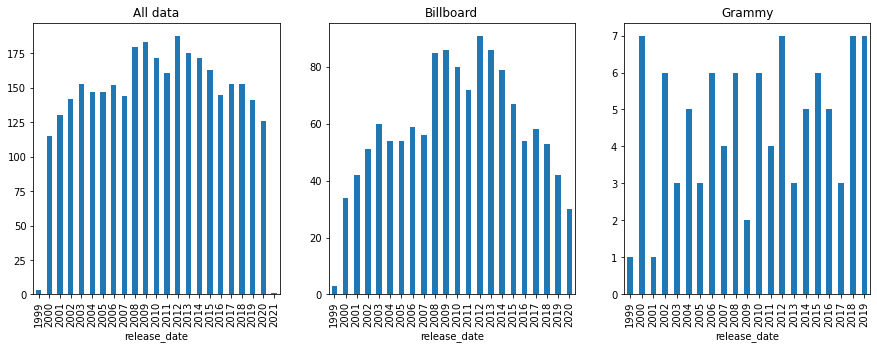

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(15)

_df_year = df.groupby([df["release_date"].dt.year]).size()
_df_year.plot.bar(ax=axes[0], title="All data")

_df_year = df_billboard.groupby([df_billboard["release_date"].dt.year]).size()
_df_year.plot.bar(ax=axes[1], title="Billboard")

_df_year = df_grammy.groupby([df_grammy["release_date"].dt.year]).size()
_df_year.plot.bar(ax=axes[2], title="Grammy")

The ideal would be to get 200 per year in Billboard, but an average of 50 is ok.

Grammy is harder to estimate, because some albums are released in one year, but runs for the award in the next year.
5 albums per year would be the ideal (2018 forwards the award started to nominate more than 5 albums). We do not have only ~10 albums out of ~105.

# Billboard position distribution

<AxesSubplot:xlabel='pos', ylabel='Count'>

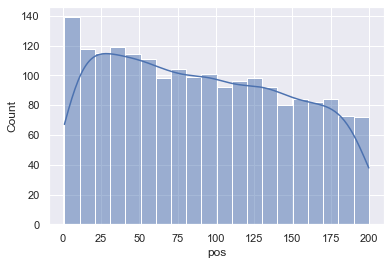

In [124]:
_billboard_positions = df_billboard["billboard"].apply(lambda d: [v for v in d.values()])
all_pos = []
for b in _billboard_positions.values:
    for v in b:
        all_pos.append(v)

_pos_df = pd.DataFrame([{"pos": a} for a in all_pos])
# _pos_df.plot.bar(xticks=[0, 25, 50, 75, 100, 125, 150, 175, 200], yticks=[0, 5, 10, 15, 20])

sns.histplot(_pos_df, x="pos", fill=True, element="bars", kde=True, bins=20)
# _pos_df

We can see that the number of album drops for the bottom of the list, which is expected

# Genres distribution

In [78]:
def count_genres(my_df, max_genres=10):
    _df = my_df["genres"]
    _df = _df.apply(lambda x: pd.Series(x, dtype=str)) # convert lists to series
    _df = _df.stack() # flatten the multiple series into a single series
    _df = _df.value_counts()
    _df = _df.sort_values(ascending=False)
    _df = _df[:max_genres]
    return _df

_df_genres_all = count_genres(df)
_df_genres_grammy = count_genres(df_grammy)
_df_genres_billboard = count_genres(df_billboard)

print(_df_genres_all.head())
print(_df_genres_grammy.head())
print(_df_genres_billboard.head())

Pop/Rock                  1049
Rock                      1011
Indie                      503
Alternative/Indie Rock     482
Rap                        477
dtype: int64
Pop/Rock    27
Rap         27
Pop         20
R&B         20
Rock        17
dtype: int64
Pop/Rock    352
Rap         317
Rock        294
Pop         254
R&B         211
dtype: int64


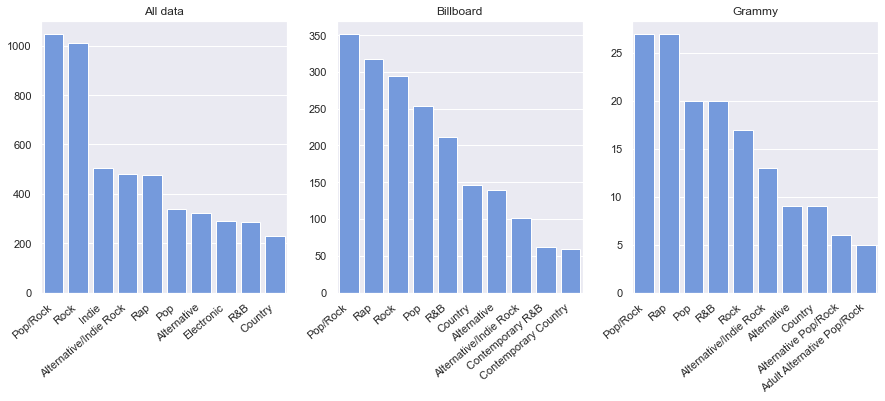

In [121]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(15)

ax = sns.barplot(x=_df_genres_all.index, y=_df_genres_all.values, ax=axes[0], color="cornflowerblue")
ax.set_title("All data")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax = sns.barplot(x=_df_genres_billboard.index, y=_df_genres_billboard.values, ax=axes[1], color="cornflowerblue")
ax.set_title("Billboard")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax = sns.barplot(x=_df_genres_grammy.index, y=_df_genres_grammy.values, ax=axes[2], color="cornflowerblue")
ax.set_title("Grammy")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.show(fig)


# Metascore Billboard (top 20)

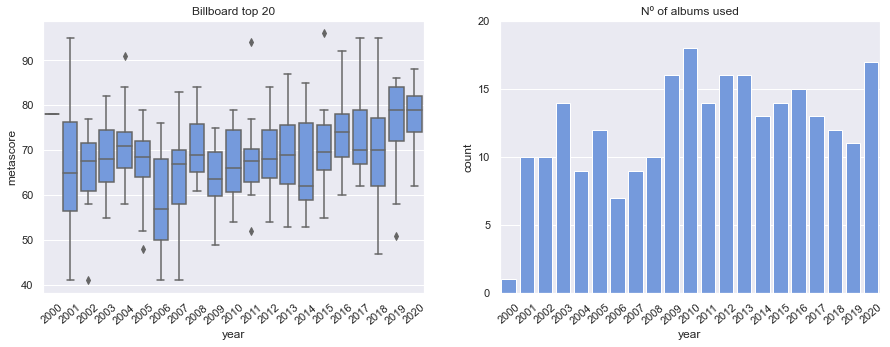

In [122]:
_df_only_billboard = pd.DataFrame(df_billboard[["billboard", "metascore", "link_album"]])
_all_billboard_data = {"metascore": [], "link_album": [], "rank": [], "year": []}
for v in _df_only_billboard.values:
    for year, rank in dict(v[0]).items():
        _all_billboard_data["metascore"].append(v[1])
        _all_billboard_data["link_album"].append(v[2])
        _all_billboard_data["year"].append(int(year))
        _all_billboard_data["rank"].append(int(rank))

_df_billboard = pd.DataFrame.from_dict(_all_billboard_data)
_df_billboard = _df_billboard[_df_billboard["rank"] <= 20]

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(15)

ax = sns.boxplot(x="year", y="metascore", data=_df_billboard, color="cornflowerblue", ax=axes[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="center")
ax.set_title("Billboard top 20")

ax = sns.countplot(x="year", data=_df_billboard, color="cornflowerblue", ax=axes[1])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="center")
ax.set_yticks([0, 5, 10, 15, 20])
ax.set_title("Nº of albums used")

plt.show(fig)


# IDEAS FOR PLOTS

- Genres distribution in Grammy/Billboard/All data (histplot)
- Metascore by position for Billboard (average)
- Metascore by year for Billboard (average), (maybe only top 10)
- Metascore for grammy albums (already done, just copy)
- Metascore by genre (boxplot)